# 7. Modern Convolutional Neural Networks(1)

## 7.1 Deep Convolutional Neural Networks(AlexNet)

Although LeNet achieved good results on early small datasets, the performance and feasibility of training CNNs on larger, more realistic datasets had yet to be established.

* parameter initialization heuristics
* clever variants of stochastic gradient descent
* non-squashing activation functions
* effective regularization techniques

AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a phenomenally large margin.

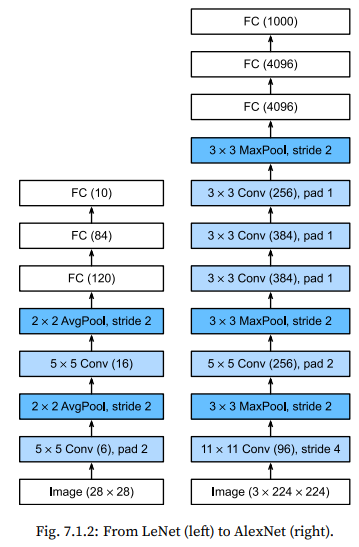

The design philosophies of AlexNet and LeNet are very similar, but there are also significant difference.

First, AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer.

Second, AlexNet used the ReLU instead of the sigmoid as its activation function.

* Architecture

a larger convolution window is needed to capture the object.

After the last convolutional layer there are two fully-connected layers with 4096 outputs. These two huge fully-connected layers produce model parameters of nearly 1GB.

* Activation Functions

Besides, AlexNet changed the sigmoid activation function to a simpler ReLU activation function.

* Capacity Control and Preprocessing

AlexNet controls the model complexity of the fully-connected layer by dropout, while LeNet only uses weight decay.

In [ ]:
pip install d2l==0.14.2

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects.
    # At the same time, we use a stride of 4 to greatly reduce the height and width of the output.
    # Here, the number of output channels is much larger than that in LeNet.
    nn.Conv2d(1, 96, kernel_size = 11, stride = 4, padding = 1), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    # Make the convolution window smaller, set padding to 2 for consistent height and width across the input and output, and increase the number of output channels.
    nn.Conv2d(96, 256, kernel_size = 5, padding = 2), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    # Use three successive convolutional layers and a small convolution window.
    # Except for the final convolutional layer, the number of output channels is further increased.
    # Pooling layers are not used to reduce the height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size = 3, padding = 1), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several times larger than that in LeNet.
    # Use the dropout layer to mitigate overfitting.
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is 10, instead of 1000 as in the paper
    nn.Linear(4096, 10)
)

In [ ]:
X = torch.randn(1, 1, 224, 224) # we construct a single-channel data with both height and width of 224 to observe the output shape of each layer. 
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224) # we upsample Fashion-MNIST to apply AlexNet

loss 0.328, train acc 0.880, test acc 0.873
415.4 examples/sec on cuda:0


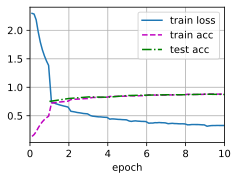

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary
* AlexNet has a similar structure to that of LeNet, but uses more convolutional layers and a larger parameter space to fit the large-scale ImageNet dataset.

* Today AlexNet has been surpassed by much more effective architectures but it is a key step from shallow to deep networks that are used nowadays.

* Although it seems that there are only a few more lines in AlexNet's implementation than in LeNet, it took the academic community many years to embrace this conceptual change and take adavantage of its excellent experimental results. This was also due to the lack of efficient computational tools.

* Dropout, ReLU, and preprocessing were the other key steps in achieving excellent performance in computer vision tasks.

## 7.2 Networks Using Blocks(VGG)

we will introduce several heuristic concepts commonly used to design deep networks.

Similarly, the design of neural network architectures had grown progressively more abstract, with researchers moving from thinking in terms of individual neurons to whole layers, and now to blocks, repeating patterns of layers.

It is easy to implement these repeated structures in code with any modern deep learning framework by using loops and subroutines.

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1))
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
  return nn.Sequential(*layers)

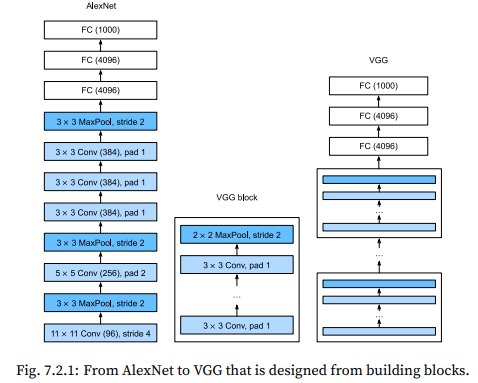


Like AlexNet and LeNet, the VGG Network can be partitioned into two parts : the first consisting mostly of convolutional and pooling layers and the second consisting of fully-connected layers.

The following variable conv_arch consists of a list of tuples (one per block), where each contains two values : the number of convolutional layers and the number of output channels, which are precisely the arguments required to call the vgg_block function.

Since this network uses 8 convolutional layers and 3 fully-connected layers, it is often called VGG-11.

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [ ]:
def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # The convolutional part
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels
  
  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # The fully-connected part
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10)
  )
net = vgg(conv_arch)

In [ ]:
# we will construct a single-channel data example with a height and width of 224
X = torch.randn(size = (1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block, finally reaching a height and width of 7 before flattening the representations for processing by the fully-connected part of the network.

Since VGG-11 is more computationally-heavy than AlexNet we construct a network with a smaller number of channels. This is more than sufficient for training a Fashion-MNIST.

In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.173, train acc 0.936, test acc 0.917
716.3 examples/sec on cuda:0


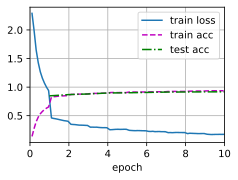

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary
* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.

* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.

* In their VGG paper, Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions(i.e., 3 x 3) were more effective than fewer layers of wider convolutions.

## 7.3 Network in Network(NiN)
LeNet, AlexNet, and VGG all share a common design pattern : extract features exploiting spatial structure via a sequence of convolution and pooling layers and then post-process the representations via fully-connected layers.

They were proposed based on a very simple insight : to use an MLP on the channels for each pixel separately.

Recall that the inputs and outputs of convolutional layers consist of four-dimensional tensors with axes corresponding to the **example, channel, height, and width**.

The idea behind NiN is to apply a fully-connected layer at each pixel location(for each height and width).

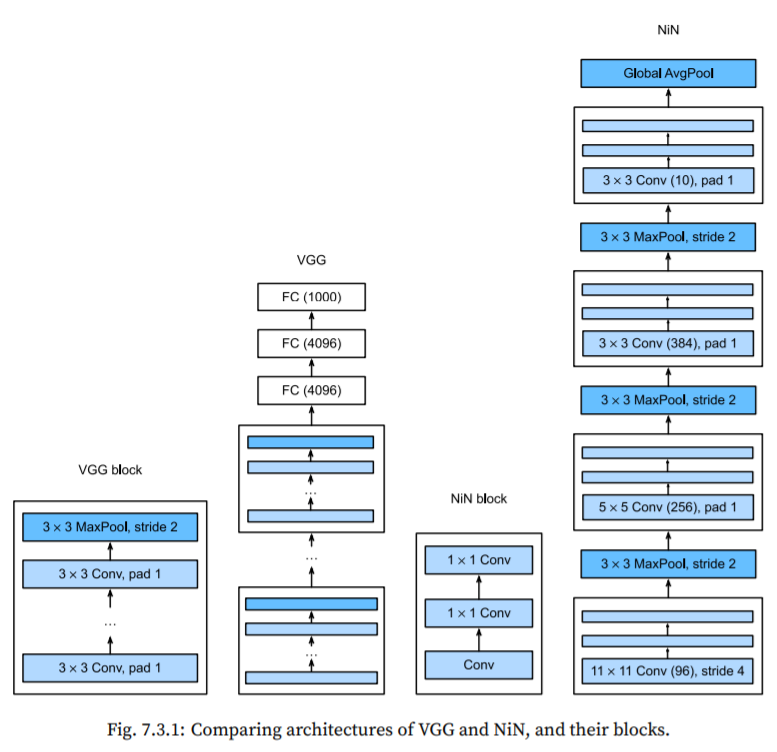

The NiN block consists of one convolutional layer followed by two 1x1 convolutional layers that act as per-pixel fully-connected layers with ReLU activations.

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size = 1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size = 1), nn.ReLU()
  )

NiN uses convolutional layers with window shapes of 11 x 11, 5 x 5, and 3 x 3, and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer with a stride of 2 and a window shape of 3 x 3.

One significant difference between NiN and AlexNet is that NiN avoids fully-connected layers altogether.

However, in practice, this design sometimes requires increased model training time.

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size = 11, strides = 4, padding = 0),
    nn.MaxPool2d(3, stride = 2),
    nin_block(96, 256, kernel_size = 5, strides = 1, padding = 2),
    nn.MaxPool2d(3, stride = 2),
    nin_block(256, 384, kernel_size = 3, strides = 1, padding = 1),
    nn.MaxPool2d(3, stride = 2),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size = 3, strides = 1, padding = 1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output wit a shape of (batch size, 10)
    nn.Flatten()
)

In [ ]:
X = torch.rand(size = (1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 1.664, train acc 0.385, test acc 0.387
1107.4 examples/sec on cuda:0


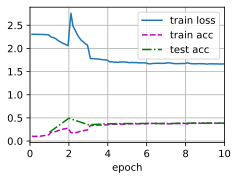

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary
* NiN uses blocks consisting of a convolutional layer and multiple 1 x 1 convolutional layers. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.

* NiN removes the fully-connected layers and replaces them with global average pooling(i.e, summing over all locations) after reducing the number of channels to the desired number of outputs(e.g., 10 for Fashion-MNIST).

* Removing the fully-connected layers reduces overfitting. NiN has dramatically fewer parameters.

* The NiN design influenced many subsequent CNN designs.

## 7.4 Networks with Parallel Concatenations (GoogLeNet)

In 2014, GooLeNet won the ImageNet Challenge, proposing a structure that combined the strengths of NiN and paradigms of repeated blocks. One focus of the paper was to address the question of which sized convolution kernels are best.

* Inception blocks

The basic convolutional block in GooLeNet is called an *Inception block*, likely named due to a quote from the movie *Inception* ("We need to go deeper"), which launched a viral meme.

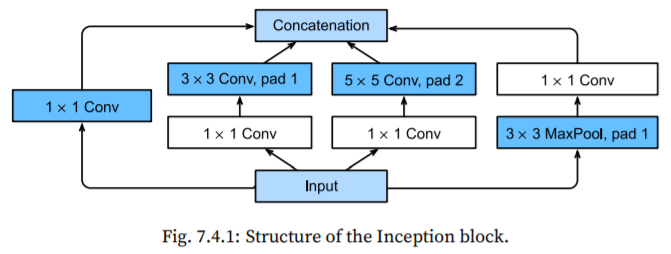

The inception block consists of four parallel paths. The first three paths use convolutional layers with window sizes of 1 x 1, 3 x 3, and 5 x 5 to extract information from different spatial sizes.

The middle two paths perform a 1 x 1 convolution on the input to reduce the number of channels, reducing the model's complexity.

The fourth path uses a 3 x 3 maximum pooling layer, followed by a 1 x 1 convolutional layer to change the number of channels.

The four paths all use appropriate padding to give the input and output the same height and width.

Finally, the outputs along each path are concatenated along the channel dimension and comprise the block's output.

The commonly-tuned hyperparameters of the Inception block are the number of output channels per layer.

In [ ]:
from torch.nn import functional as F

In [ ]:
class Inception(nn.Module):
  # `c1`--`c4` are the number of output channels for each path
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(*kwargs)
    # Path 1 is a single 1x1 convolutional layer
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size = 1)
    # Path 2 is a 1x1 convolutional layer followed by a 3x3 convolutional layer
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size = 1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size = 3, padding = 1)
    # Path 3 is a 1x1 convolutional layer followed by a 5x5 convolutional layer
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size = 1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size = 5, padding = 2)
    # Path 4 is a 3x3 maximum pooling layer followed by a 1x1 convolutional layer
    self.p4_1 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size = 1)
  
  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # Concatenate the outputs on the channel dimension
    return torch.cat((p1, p2, p3, p4), dim = 1)

To gain some intuition for why this network works so well, consider the combination of the filters. They explore the image in a variety of filter sizes.

This means that details at different extents can be recognized efficiently by filters of different sizes.

At the same time, we can allocate different amouts of parameters for different filters.

GoogLeNet uses a stack of a total 9 inception blocks and global average pooling to generate its estimates.

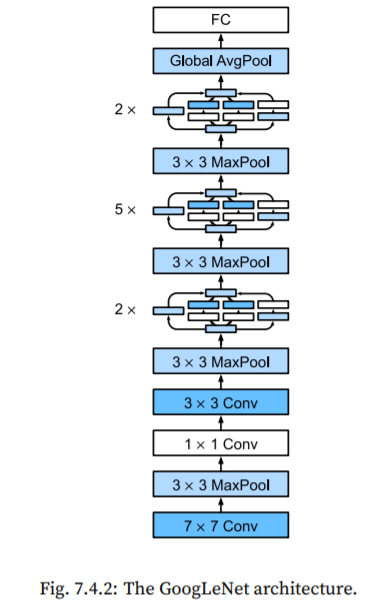

In [ ]:
# the first module uses a 64-channel 7 x 7 convolutional layer
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
                   )

In [ ]:
# the second module uses two convolutional layers: first, a 64-channel 1x1 convolutional layer, then a 3x3 convolutional layer that triples the number of channels.
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size = 3, padding = 1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
)

The number of output channels of the first Inception block is 64+128+32+32 = 256, and the number-of-output-channel ratio among the four paths is 64:128:32:32 = 2:4:1:1.

The numbrer of output channels of the second Inception block is increased to 128+192+96+64 = 480, and the number-of-output-channel ratio among the four path is 128:192:96:64 = 4:6:3:2.

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
                   )

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
)

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten()
)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# to have a reasonable training time on Fashion-MNIST, we reduce the input height and width from 224 to 96. This simplifies the computation.
X = torch.rand(size = (1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.249, train acc 0.905, test acc 0.896
1115.2 examples/sec on cuda:0


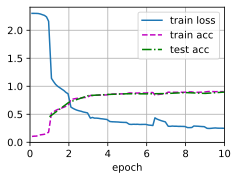

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary
* The Inception block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers. 1x1 convolutions reduce channel dimensionality on a per-pixel level. Maximum pooling reduces the resolution.

* GoogLeNet connects multiple well-designed Inception blocks with other layers in series. The ratio of the number of channels assigned in the Inception block is obtained through a large number of experiments on the ImageNet dataset.

* GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.